<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiLabel_LogisticRegression_Doc2VecVectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model with Doc2vec and Logistic Regression

In this notebook, we are going to use a Logistic Regression Model to predict categories of text. Logistic regression is a simple and easy to understand classification algorithm, and Logistic regression can be easily generalized to multiple classes. To vectorize the text we are going to use the Doc2Vec. Doc2Vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method. 

Doc2Vect: 
- https://cs.stanford.edu/~quocle/paragraph_vector.pdf
- https://radimrehurek.com/gensim/models/doc2vec.html
- https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e


Notebook adapted from: 
- https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
- https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4



In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Data

### Fetch data

We are using a relatively large data set of Stack Overflow questions and tags.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
categories = df["tags"].unique()

print(f'Number of examples : {len(df)}')
print(f'Number of words in the data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')
print(f'Number of categorie : {len(categories)}')
print()
print(df.head(10))
print()
print(f'Categories: {categories}')


Number of examples : 40000
Number of words in the data: 10286120
Number of categorie : 20

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

Categories: ['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'my

Visualize data

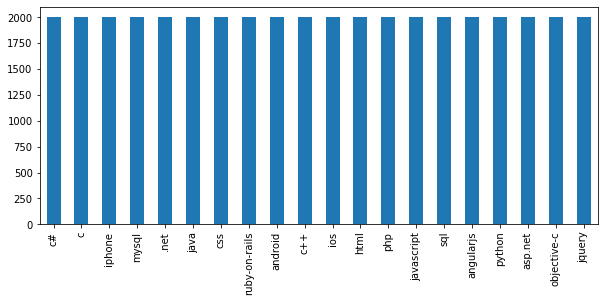

In [4]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

### Text pre-processing

Our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [5]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

print(f'Example text previous cleaning : {df["post"].values[10]}')

df['post'] = df['post'].apply(clean_text)

print(f'Example text previous cleaning : {df["post"].values[10]}')

Example text previous cleaning : when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interf

In [7]:
print(f'Number of words in the cleaning data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')

Number of words in the cleaning data: 3424297


## Model training

First we load a word2vec model. It has been pre-trained by Google on a 100 billion word Google News corpus.

### Doc2Vec

* **Prepare data**

We split the data to train and evaluation examples

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of evaluation examples: {len(X_test)}')

Number of training examples: 28000
Number of evaluation examples: 12000


* **Doc2Vect text adaption**

First, we label the sentences. Gensim’s Doc2Vec implementation requires each document/paragraph to have a label associated with it. and we do this by using the TaggedDocument method. The format will be “TRAIN_i” or “TEST_i” where “i” is a dummy index of the post.

In [0]:
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

According to Gensim doc2vec tutorial, its doc2vec class was trained on the entire data, and we will do the same. Let’s have a look what the tagged document looks like:

In [16]:
all_data[:2]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', '11', 'auto_increment', 'name', 'varchar', '150', 'lastname', 'varchar', '150', 'company', 'varchar', '250', 'adress', 'varchar', '150', 'postcode', 'int', '5', 'city', 'varchar', '150', 'email', 'varchar', '250', 'phone', 'varchar', '20', 'orgnr', 'varchar', '15', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name',

* **Doc2Vec training**

We initialize the model with the following parameters:
 * `dm=0` , distributed bag of words (DBOW) is used.
 * `vector_size=300` , 300 vector dimensional feature vectors.
 * `negative=5` , specifies how many “noise words” should be drawn.
 * `min_count=1` , ignores all words with total frequency lower than this.
 * `alpha=0.065` , the initial learning rate.

In [17]:
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 40000/40000 [00:00<00:00, 1604599.98it/s]


We train for 30 epochs and the 

In [18]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 40000/40000 [00:00<00:00, 2306717.26it/s]


* **Word embeddings using Doc2Vec**

We get vectors from trained doc2vec model.

In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

### Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)

We train the vectorizers and model

In [21]:
%%time
logreg = logreg.fit(train_vectors_dbow, y_train)

CPU times: user 1min 29s, sys: 35.1 ms, total: 1min 29s
Wall time: 1min 29s


## Model evaluation

In [23]:
%%time
from sklearn.metrics import classification_report
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.8080833333333334
               precision    recall  f1-score   support

           c#       0.72      0.68      0.70       589
      asp.net       0.90      0.91      0.90       661
  objective-c       0.93      0.95      0.94       606
         .net       0.80      0.78      0.79       613
       python       0.84      0.89      0.87       601
    angularjs       0.71      0.71      0.71       585
       iphone       0.87      0.81      0.84       621
ruby-on-rails       0.81      0.85      0.83       587
          ios       0.68      0.66      0.67       560
            c       0.67      0.68      0.67       611
          sql       0.66      0.67      0.66       593
         java       0.81      0.86      0.83       581
       jquery       0.81      0.77      0.79       608
          css       0.85      0.85      0.85       593
          c++       0.85      0.82      0.83       592
          php       0.72      0.65      0.68       597
      android       0.85      0.86  

In [0]:
import itertools

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

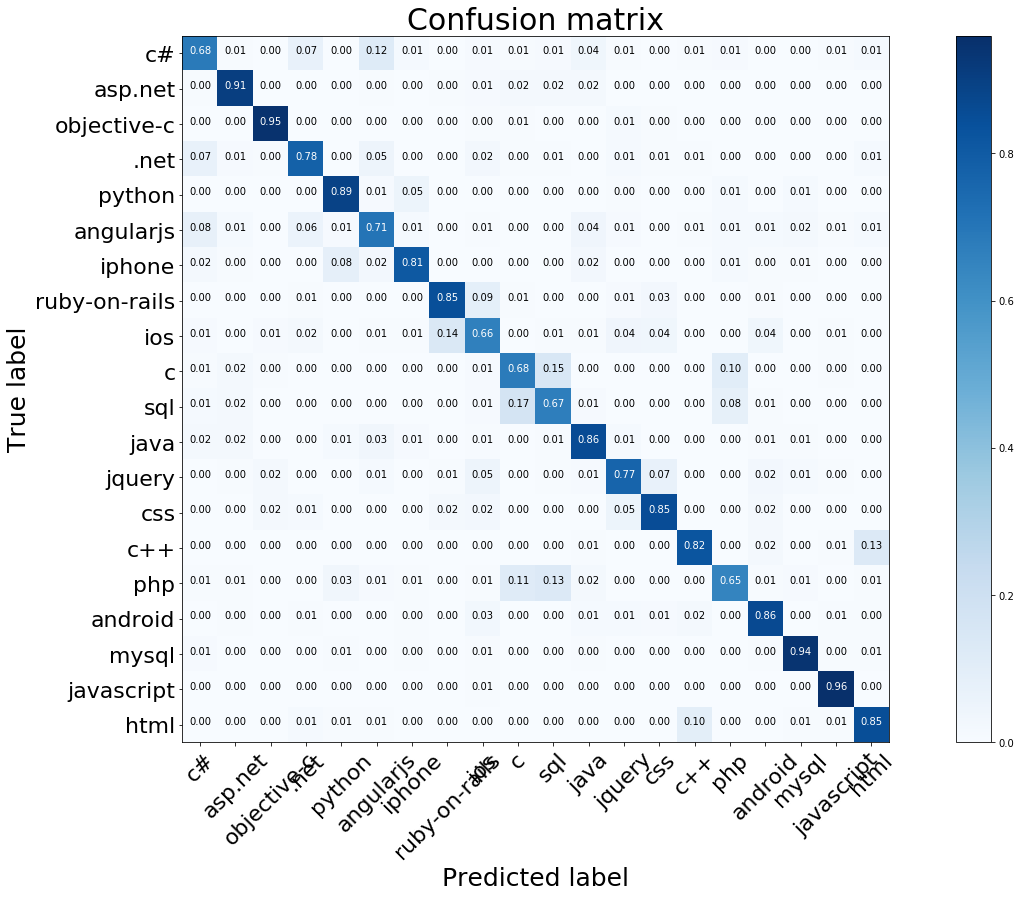

In [31]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(24,13))
plot_confusion_matrix(cnf_matrix, classes=categories, title="Confusion matrix")
plt.show()